# We're going to try fitting a full asymptotic relation to some simulated data

We'll do Gaussian noise cos it makes my life easier

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import theano.tensor as tt

import lightkurve as lk
from astropy.units import cds
from astropy import units as u
import seaborn as sns

import corner
import pystan
import pandas as pd
import pickle
import glob
from astropy.io import ascii
import os

import pymc3 as pm
import arviz

## Build the model

In [3]:
class model():
    def __init__(self, f, n0_, n1_, n2_):
        self.f = f
        self.n0 = n0_
        self.n1 = n1_
        self.n2 = n2_
        self.npts = len(f)
        self.M = [len(n0_), len(n1_), len(n2_)]
        
    def epsilon(self, i, theano=True):
        eps = tt.zeros((3,3))
        eps0 = tt.set_subtensor(eps[0][0], 1.)
        eps1 = tt.set_subtensor(eps[1][0], tt.cos(i)**2)
        eps1 = tt.set_subtensor(eps1[1], 0.5 * tt.sin(i)**2)
        eps2 = tt.set_subtensor(eps[2][0], 0.25 * (3. * tt.cos(i)**2 - 1.)**2)
        eps2 = tt.set_subtensor(eps2[1], (3./8.)*tt.sin(2*i)**2)
        eps2 = tt.set_subtensor(eps2[2], (3./8.) * tt.sin(i)**4)

        eps = tt.set_subtensor(eps[0], eps0)
        eps = tt.set_subtensor(eps[1], eps1)
        eps = tt.set_subtensor(eps[2], eps2)
        
        if not theano:
            return eps.eval()
        return eps
            

    def lor(self, freq, h, w):
        return h / (1.0 + 4.0/w**2*(self.f - freq)**2)
    
    def mode(self, l, freqs, hs, ws, eps, split=0):
        for idx in range(self.M[l]):
            for m in range(-l, l+1, 1):
                self.modes += self.lor(freqs[idx] + (m*split), 
                                     hs[idx] * eps[l,abs(m)], 
                                     ws[idx])
  
    def model(self, p, theano=True):
        f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, b = p
               
        # Calculate the modes
        eps = self.epsilon(i, theano)        
        self.modes = np.zeros(self.npts)
        self.mode(0, f0, h0, g0, eps)
        self.mode(1, f1, h1, g1, eps, split)
        self.mode(2, f2, h2, g2, eps, split)
               
        #Create the model
        self.mod = self.modes + b
        return self.mod

    def asymptotic(self, n, numax, deltanu, alpha, epsilon):       
        nmax = (numax / deltanu) - epsilon
        over = (n + epsilon + ((alpha/2)*(nmax - n)**2))
        return over * deltanu
    
    def f0(self, p):
        numax, deltanu, alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n0, numax, deltanu, alpha, epsilon)
    
    def f1(self, p):
        numax, deltanu, alpha, epsilon, d01, d02 = p
        
        f0 = self.asymptotic(self.n1, numax, deltanu, alpha, epsilon)
        return f0 + d01
    
    def f2(self, p):
        numax, deltanu, alpha, epsilon, d01, d02 = p
        
        f0 = self.asymptotic(self.n2+1, numax, deltanu, alpha, epsilon)
        return f0 - d02

In [4]:
nmodes = 2   # Two overtones
nbase = 18   # Starting at n = 18
n0_ = np.arange(nmodes)+nbase
n1_ = np.copy(n0_)
n2_ = np.copy(n0_) - 1.
fs = .05     # Data has a frequency spacing of 0.05 microhertz
nyq = (0.5 * (1./58.6) * u.hertz).to(u.microhertz).value  # Setting a sensible nyquist value
ff = np.arange(fs, nyq, fs)  # Generating the full frequency range

Set the asymptotic parameters

In [5]:
deltanu_  =  60.
numax_= 1150.
alpha_ = 0.
epsilon_ = 0.
d01_ = deltanu_/2.
d02_ = 6.

Generate the model for the full range

In [6]:
mod = model(ff, n0_, n1_, n2_)

Calculate the predicted mode frequencies

In [7]:
init_f = [numax_, deltanu_, alpha_, epsilon_, d01_, d02_]
f0_ = mod.f0(init_f)
f1_ = mod.f1(init_f)
f2_ = mod.f2(init_f)

Slice up the data to just be around the mode frequencies

In [8]:
lo = f2_.min() - .25*deltanu_
hi = f1_.max() + .25*deltanu_

sel = (ff > lo) & (ff < hi)
f = ff[sel]

And now lets reset the model for the new frequency range...

In [9]:
mod = model(f, n0_, n1_, n2_)

Set up initial guesses for the model parameters

In [10]:
def gaussian(locs, l, numax, Hmax0):
    fwhm = 0.25 * numax
    std = fwhm/2.355

    Vl = [1.0, 1.22, 0.71, 0.14]

    return Hmax0 * Vl[l] * np.exp(-0.5 * (locs - numax)**2 / std**2)

In [11]:
init_m =[f0_,                         # l0 modes
           f1_,                         # l1 modes
           f2_,                         # l2 modes
           np.ones(len(f0_)) * 2.0,     # l0 widths
           np.ones(len(f1_)) * 2.0,     # l1 widths
           np.ones(len(f2_)) * 2.0,     # l2 widths
           np.sqrt(gaussian(f0_, 0, numax_, 1000.) * 2.0 * np.pi / 2.0) ,# l0 heights
           np.sqrt(gaussian(f1_, 1, numax_, 1000.) * 2.0 * np.pi / 2.0) ,# l1 heights
           np.sqrt(gaussian(f2_, 2, numax_, 1000.) * 2.0 * np.pi / 2.0) ,# l2 heights
           1.,       # splitting
           np.pi/4.,                    # inclination angle
           1.                           # background parameters
        ]

# Add on the chisquare 2 dof noise
p = mod.model(init_m, theano=False)*np.random.chisquare(2., size=len(f))/2

Plot what our data looks like

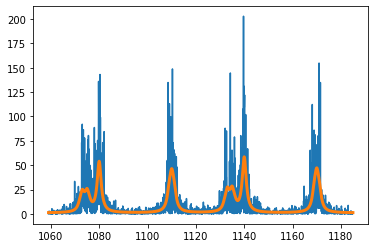

In [14]:

plt.plot(f, p)
plt.plot(f, mod.model(init_m, theano=False), lw=3)
plt.show()

plt.show()    

# Fitting the model:

In [70]:
pm_model = pm.Model()

with pm_model:   
    epsilon = pm.Normal('epsilon', 0, 1)
    dnu = pm.Normal('dnu', 60, 0.01)
    d02 = pm.Normal('d02', 0.1, 0.01)
    d01 = pm.Normal('d01', 0.5, 0.01)
    
    f0 = pm.Normal('f0', (n0_ + epsilon) * dnu, 1.0, shape=2)
    f1 = pm.Normal('f1', (n0_ + epsilon + d01) * dnu, 1.0, shape=2)
    f2 = pm.Normal('f2', (n0_ + epsilon - d02) * dnu, 1.0, shape=2)
    
    split = pm.Lognormal('split', np.log(0.4), 0.1)
    i = 70.0
    g = pm.Lognormal('g', np.log(1.0), 0.1, shape=2)
    h = pm.Lognormal('h', np.log(50.0), 0.1, shape=2)
    b = 1.0
    
    fit = mod.model([f0, f1, f2, g, g, g, h, h, h, split, i, b])
    
    like = pm.Gamma('like', alpha=1., beta=1./fit, observed=p)
    '''
    
    # I've left these below for you to use if you want because I trust these parameterizations
    xsplit = pm.HalfNormal('xsplit', sigma=2.0, testval=init_m[9] * np.sin(init_m[10]))
    cosi = pm.Uniform('cosi', 0., 1., testval=np.cos(init_m[10]))
    
    i = pm.Deterministic('i', tt.arccos(cosi))
    split = pm.Deterministic('split', xsplit/tt.sin(i))
    
    b = pm.Bound(pm.Normal, lower=0.)('b', mu=1., sigma=.1, testval=1.)
    
    fit = mod.model([f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, b])
    
    like = pm.Gamma('like', alpha=1., beta=1./fit, observed=p)
    '''

In [63]:
with pm_model:
    inference = pm.ADVI()
    approx = pm.fit(n=90000, method=inference)

Average Loss = 6,354.7: 100%|██████████| 90000/90000 [02:22<00:00, 632.18it/s]
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 6,354.7


In [64]:
start = dict(pm.summary(approx.sample(draws=1000)).mean(axis=1))

In [71]:
with pm_model:
    trace = pm.sample(1000, start=start)

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [h, g, split, f2, f1, f0, d01, d02, dnu, epsilon]
Sampling 4 chains: 100%|██████████| 6000/6000 [01:52<00:00, 53.46draws/s] 


In [66]:
pm.summary(trace)

/home/davies/.local/lib/python3.6/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
epsilon,0.033651,0.188068,0.002972,-0.338479,0.393485,3476.035030,0.999991
dnu,59.896656,0.603473,0.009466,58.745472,61.102807,3491.384581,0.999953
d02,0.099707,0.008499,0.000112,0.083306,0.116617,5634.782653,0.999947
d01,0.499823,0.008598,0.000113,0.482945,0.516203,5862.408206,0.999713
f0__0,1079.974497,0.122553,0.001508,1079.737263,1080.204854,6055.636041,0.999604
f0__1,1139.921581,0.127920,0.001467,1139.685911,1140.180005,6346.562825,0.999903
f1__0,1109.909901,0.112047,0.001266,1109.700028,1110.133521,6997.026207,0.999634
f1__1,1169.911174,0.113358,0.001432,1169.690724,1170.126558,5552.266504,0.999598
f2__0,1074.256654,0.148773,0.002087,1073.966681,1074.549574,4849.457515,0.999701
f2__1,1133.849627,0.195715,0.002702,1133.465436,1134.225743,5174.287755,0.999857


In [67]:
pm.summary(approx.sample(draws=1000))

,mean,sd,mc_error,hpd_2.5,hpd_97.5
epsilon,0.022947,0.007712,0.000232,0.009477,0.039353
dnu,59.926872,0.024362,0.000818,59.878888,59.973289
d02,0.099546,0.008452,0.000263,0.084299,0.116283
d01,0.499405,0.008535,0.000276,0.484030,0.517693
f0__0,1079.980400,0.135797,0.004459,1079.700728,1080.236727
f0__1,1139.905523,0.137834,0.004314,1139.641747,1140.174168
f1__0,1109.902482,0.120155,0.003787,1109.692032,1110.156054
f1__1,1169.901078,0.119766,0.003335,1169.667126,1170.133536
f2__0,1074.263681,0.157679,0.004481,1073.962764,1074.568150
f2__1,1133.862957,0.200448,0.005918,1133.526560,1134.309790
